In [60]:
%matplotlib inline

from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

import sklearn
import yuv

# Video loading

In [47]:
# NOTE(ajayjain): This list may be missing a video
videos = [
    "./data/live/rh1_25fps.yuv",
    "./data/live/st1_25fps.yuv",
    "./data/live/pa1_25fps.yuv",
    "./data/live/tr1_25fps.yuv",
    "./data/live/bs1_25fps.yuv",
    "./data/live/mc1_50fps.yuv",
    "./data/live/sf1_25fps.yuv",
    "./data/live/rb1_25fps.yuv",
    "./data/live/sh1_50fps.yuv",
    "./data/live/pr1_50fps.yuv",
]

# Frame dimensions
dim = (768, 432)

In [7]:
video_matrix, frames = yuv.load_YUV420_video(videos[0], dim)

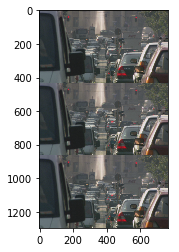

In [8]:
rgb_frames = yuv.convert_pil_ycbcr_to_rgb(frames)
stacked_frames = np.concatenate(rgb_frames)
plt.imshow(stacked_frames[:dim[1]*3, :, :])

In [52]:
def frame_vector_to_rgb(frame, dimensions):
    """Converts a image vector an RGB numpy array.
   
    Args:
        frame: vector of YUV data, scaled from 0 to 1
        dimensions: tuple/list/ndarray containing the width and height of the desired frame
    """
    Y_components = dimensions[0] * dimensions[1]
    U_components = Y_components // 4
    V_components = Y_components // 4
    
    UV_dimensions = (dimensions[0] // 2, dimensions[1] // 2)
   
    frame = np.uint8(frame * 255)

    y = Image.frombytes('L', dimensions, frame[:Y_components])
    u = Image.frombytes('L', UV_dimensions, frame[Y_components:Y_components+U_components])\
             .resize(dimensions)
    v = Image.frombytes('L', UV_dimensions, frame[Y_components+U_components:Y_components+U_components+V_components])\
             .resize(dimensions)

    image = Image.merge('YCbCr', (y, u, v)).convert('RGB')
    return image

# Non-negative matrix factorization of video byte matrix

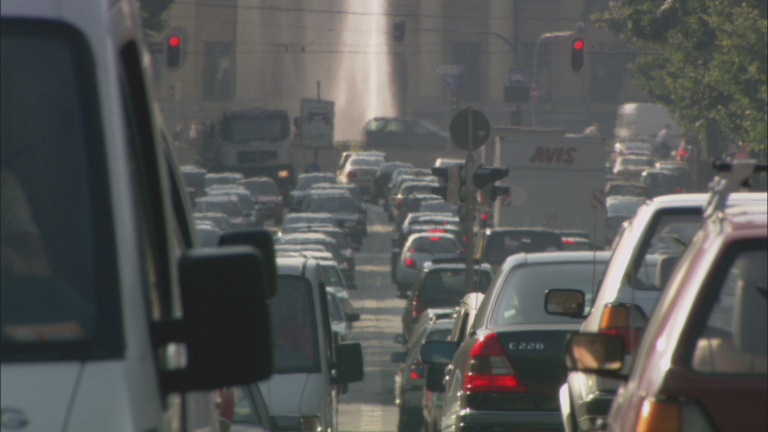

In [58]:
# Transpose video matrix: num frames by num components
frames = video_matrix.T
# Scale from 0 to 1
frames = frames.astype(np.float32) / 255.

frame_vector_to_rgb(frames[0], dim)

# eps = 1e-5
# frame_mean = frames.mean(axis=0)
# frame_std = frames.std(axis=0) + eps
# frames = (frames - frame_mean) / frame_std

In [80]:
nmf = sklearn.decomposition.NMF(n_components=20, verbose=True)
W = nmf.fit_transform(frames[:30, :])

violation: 1.0
violation: 0.5739701619530707
violation: 0.40314204062674075
violation: 0.28548086991251237
violation: 0.20902645338381495
violation: 0.16295415664871338
violation: 0.13245526925951265
violation: 0.11068972362957168
violation: 0.09471921898807999
violation: 0.0831356456793086
violation: 0.0742888157827879
violation: 0.06735405059644227
violation: 0.06173684060180578
violation: 0.05712151714164543
violation: 0.05320127244644741
violation: 0.0498377719621518
violation: 0.04698215281121593
violation: 0.04452773336000466
violation: 0.04236169987862331
violation: 0.04045007039900298
violation: 0.038780172885231536
violation: 0.037242460718145555
violation: 0.035836532167796156
violation: 0.034518650144122566
violation: 0.03331855818317885
violation: 0.03222482927779347
violation: 0.031215704254810902
violation: 0.030269178787113788
violation: 0.029411520349787605
violation: 0.02862619722250084
violation: 0.027868257817123442
violation: 0.027161832827713266
violation: 0.026492

In [81]:
H = nmf.components_

In [105]:
W_uint8 = np.uint8(W * 255)
H_uint8 = np.uint8(H * 255)

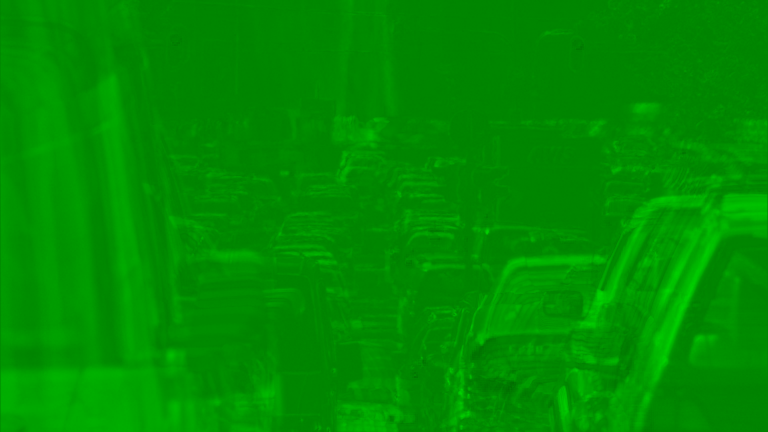

In [107]:
reconstructed = (W_uint8.astype(np.float32) / 255.) @ (H_uint8.astype(np.float32) / 255.)
frame_vector_to_rgb(reconstructed[0], dim)

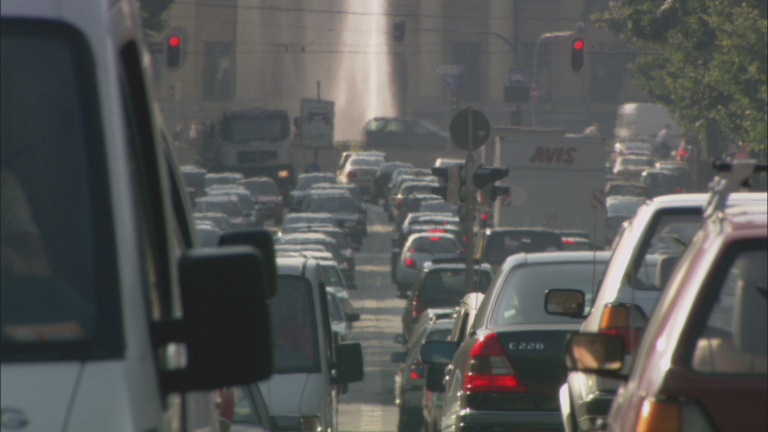

In [108]:
frame_vector_to_rgb(frames[0], dim)

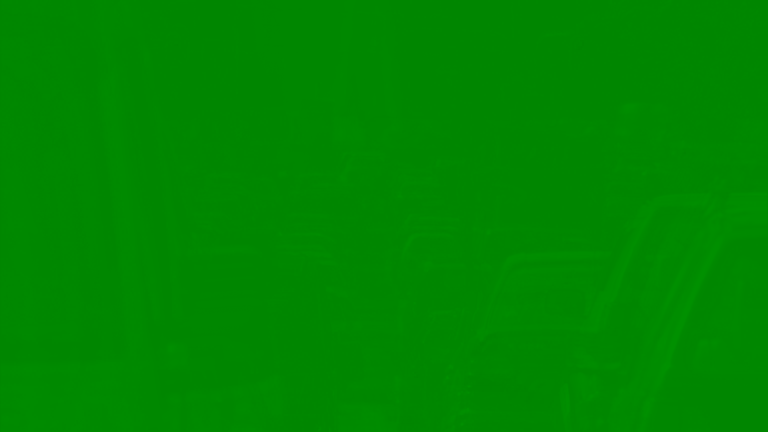

In [101]:
frame_vector_to_rgb(H[19], dim)

In [91]:
np.sum((frames[:30, :] - reconstructed)**2)

1058.8999911841145